In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pycountry_convert as pc

<b> Clash Royale Data Intern Test 

Omar Nasri </b>

In [2]:
con = sqlite3.connect("sample.sqlite")

#create dfs from tables provided
account = pd.read_sql_query("SELECT * from account", con)
account_date_session = pd.read_sql_query("SELECT * from account_date_session", con)
iap_purchase = pd.read_sql_query("SELECT * from iap_purchase", con)

con.close()

In [3]:
account.head()

,account_id,created_time,created_device,created_platform,country_code,created_app_store_id
0,13514010,2016-03-02 17:11:00.332,"iPhone6,2",iOS,GB,1
1,4308483975,2016-03-02 20:57:46.14,MIDC147PJ,Android,FR,2
2,17193137415,2016-03-02 13:52:16.735,SM-G360F,Android,IT,2
3,21488104920,2016-03-02 12:43:27.899,H60-L01,Android,CN,8
4,21488107995,2016-03-02 17:20:12.145,GT-I9500,Android,RU,2


This dataset includes information that provide details into the user's account creation process, including the time, device, platform, and geographical location.

In [4]:
account_date_session.head()

,account_id,date,session_count,session_duration_sec
0,68730811144,2016-01-01,1,47
1,68730812806,2016-01-01,1,204
2,68730829426,2016-01-01,12,4703
3,68730829426,2016-01-02,9,4676
4,68730829426,2016-01-03,9,2271


This dataset contains records of user accounts which allows tracking user activity over time by providing information on the frequency and duration of sessions for each account.

In [5]:
iap_purchase.head()

,account_id,created_time,package_id_hash,iap_price_usd_cents,app_store_id
0,30077202816,2016-03-26 23:59:59.355,ae0253c27c34edd1ab4fe21d6bfc91f8,739,0
1,30077202816,2016-05-31 11:24:37.283,dd4c1bda4f2c904075fb2fbfcf30f30e,369,0
2,21487283560,2016-02-13 03:40:28.644,99a9e0e63efa2fdce8fc8de74c66cea9,184,0
3,21487152816,2016-02-28 00:53:26.678,99a9e0e63efa2fdce8fc8de74c66cea9,184,0
4,8602037685,2016-02-11 01:03:04.727,99a9e0e63efa2fdce8fc8de74c66cea9,184,0


This dataset captures information related to in-app purchases. Each row represents a specific in-app purchase, providing insights into user spending behavior within the application.

2. Analyse the daily active users:

• Compare DAU changes over time.

• Can you identify any trends in data?

• Can you find any ups or drops that are out of the normal behaviour?

• What do you think why do they happen?

Text(0, 0.5, 'Number of Users')

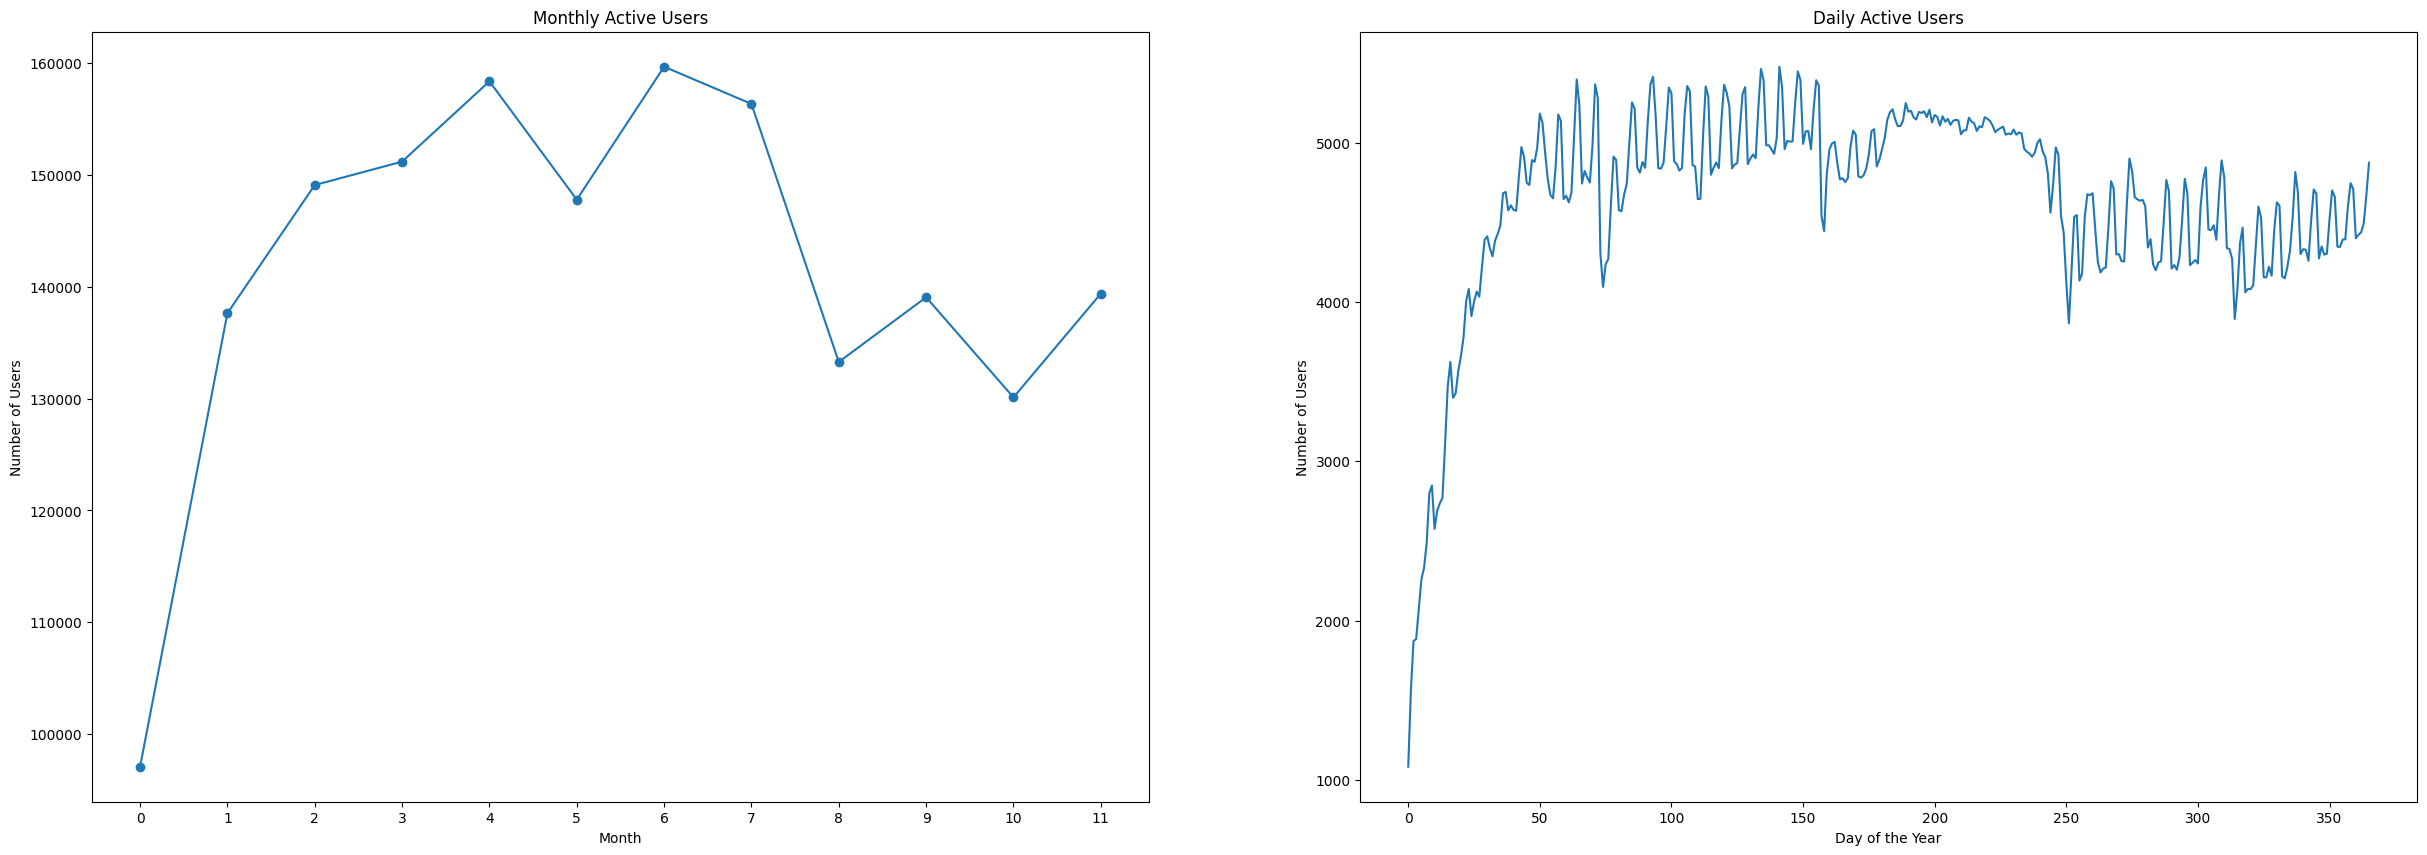

In [6]:

# Convert 'date' to a datetime
account_date_session['date'] = pd.to_datetime(account_date_session['date'])

# Group by month and calculate monthly active users for each month
monthly_active_users = account_date_session.groupby(account_date_session['date'].dt.to_period("M"))['account_id'].count().tolist()

# Create a list with the daily active users each day of the year
daily_active_users = account_date_session.groupby('date')['account_id'].count().tolist()


fig, axs = plt.subplots(1, 2, figsize=(30, 10))

# Plot the daily active users by month
axs[0].plot(monthly_active_users, marker='o', linestyle='-')
axs[0].set_title('Monthly Active Users')
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Number of Users')
axs[0].set_xticks(range(len(monthly_active_users)))


# Plot the daily active users for each day of the year
axs[1].plot(daily_active_users)
axs[1].set_title('Daily Active Users')
axs[1].set_xlabel('Day of the Year')
axs[1].set_ylabel('Number of Users')


The daily active users shows a strong trend towards new players in the beginning. On the first 2 months the growth in daily players is very fast but after this the growth stops. There are clear seasonal fluctuations as the summer months seem to have higher count of active users. The decline in active users following the summer months suggests that the end of holidays may have contributed to a decrease in app usage. After a period of initial growth, the app appears to have reached a steady state in terms of user activity, with fairly small fluctuations in active user counts.

3. Analyse sales:

• Analyse the geographic split of the revenue and the users.

• Calculate average revenue per user per market.

• What are your observations of the results?

In [7]:
def get_continent_code(country_code):
    try:
        return pc.country_alpha2_to_continent_code(country_code)
    except Exception as e:
        return 'Unknown'

# Apply the function to create the 'continent' column
account['continent'] = account['country_code'].apply(lambda x: get_continent_code(x))

#Convert continent column to continent name 
account['continent'] = account['continent'].map({'NA': 'North America', 'SA': 'South America', 'AS': 'Asia', 'OC': 'Oceania', 'AF': 'Africa', 'EU': 'Europe'})

#join continent column to iap_purchase table by account_id
iap_purchase = pd.merge(iap_purchase, account[['account_id', 'continent']], on='account_id', how='left')


Text(0, 0.5, 'Total Revenue ($)')

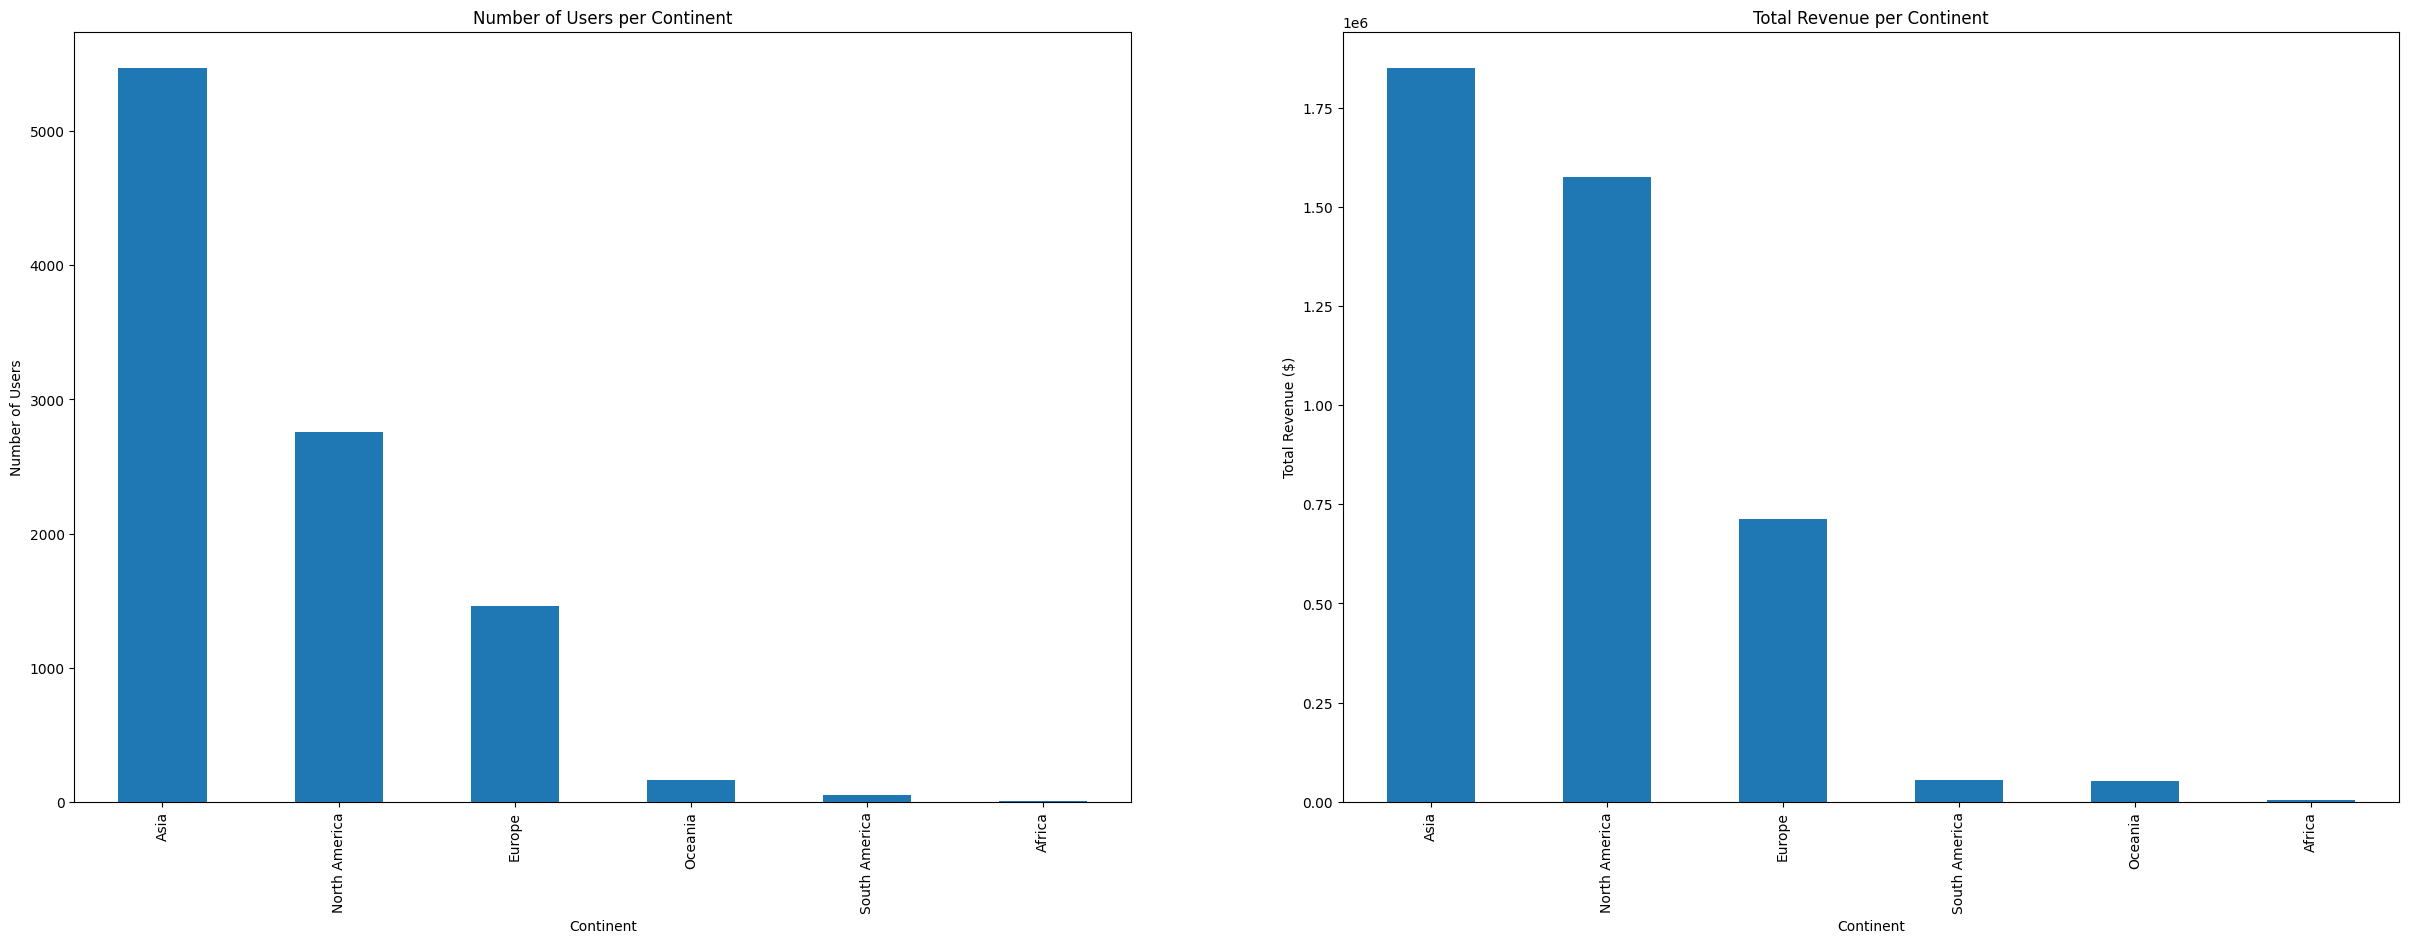

In [8]:
# Set up subplots
fig, axs = plt.subplots(1, 2, figsize=(30, 10))

# Plot the number of users by continent
iap_purchase['continent'].value_counts().plot(kind='bar', ax=axs[0])
axs[0].set_title('Number of Users per Continent')
axs[0].set_xlabel('Continent')
axs[0].set_ylabel('Number of Users')

# Plot the total revenue by continent
iap_purchase.groupby('continent')['iap_price_usd_cents'].sum().sort_values(ascending=False).plot(kind='bar', ax=axs[1])
axs[1].set_title('Total Revenue per Continent')
axs[1].set_xlabel('Continent')
axs[1].set_ylabel('Total Revenue ($)')


In [9]:
#Calculate average revenue per user per market
revenue_per_user = iap_purchase.groupby('continent')['iap_price_usd_cents'].sum() / iap_purchase.groupby('continent')['account_id'].nunique()
revenue_per_user = revenue_per_user.sort_values(ascending=False)
print(revenue_per_user/100) 


continent
South America    55.747000
North America    52.357409
Europe           33.493756
Oceania          18.947778
Asia             18.626012
Africa           12.070000
dtype: float64


The results indicate that customers in Asia generally spend significantly less on the game. Although North America has nearly half the number of players compared to Asia, the revenue disparity between these regions appears relatively small. 